In [1]:
%env CUDA_VISIBLE_DEVICES=3
import os
import math
import torchkbnufft

import h5py
import numpy as np
import pylab as plt
plt.style.use('dark_background')
import pandas as pd
from tqdm import tqdm

import random
import torch
import torch.utils.data
import torch.nn.functional as F
from k_space_reconstruction.utils.kspace import EquispacedMaskFunc, RandomMaskFunc
from k_space_reconstruction.utils.kspace import pt_spatial2kspace as Ft
from k_space_reconstruction.utils.kspace import pt_kspace2spatial as IFt
from k_space_reconstruction.nets.unet import Unet

torch.manual_seed(228)
random.seed(228)
np.random.seed(228)

env: CUDA_VISIBLE_DEVICES=3


In [2]:
def mrisensesim(size, ncoils=8, array_cent=None, coil_width=2, n_rings=None, phi=0):
    """Apply simulated sensitivity maps. Based on a script by Florian Knoll.

    Args:
        size (tuple): Size of the image array for the sensitivity coils.
        nc_range (int, default: 8): Number of coils to simulate.
        array_cent (tuple, default: 0): Location of the center of the coil
            array.
        coil_width (double, default: 2): Parameter governing the width of the
            coil, multiplied by actual image dimension.
        n_rings (int, default: ncoils // 4): Number of rings for a
            cylindrical hardware set-up.
        phi (double, default: 0): Parameter for rotating coil geometry.

    Returns:
        list: A list of dimensions (ncoils, (N)), specifying spatially-varying
            sensitivity maps for each coil.
    """
    if array_cent is None:
        c_shift = [0, 0, 0]
    elif len(array_cent) < 3:
        c_shift = array_cent + (0,)
    else:
        c_shift = array_cent

    c_width = coil_width * min(size)

    if len(size) > 2:
        if n_rings is None:
            n_rings = ncoils // 4

    c_rad = min(size[0:1]) / 2
    smap = []
    if len(size) > 2:
        zz, yy, xx = np.meshgrid(
            range(size[2]), range(size[1]), range(size[0]), indexing="ij"
        )
    else:
        yy, xx = np.meshgrid(range(size[1]), range(size[0]), indexing="ij")

    if ncoils > 1:
        x0 = np.zeros((ncoils,))
        y0 = np.zeros((ncoils,))
        z0 = np.zeros((ncoils,))

        for i in range(ncoils):
            if len(size) > 2:
                theta = np.radians((i - 1) * 360 / (ncoils + n_rings) + phi)
            else:
                theta = np.radians((i - 1) * 360 / ncoils + phi)
            x0[i] = c_rad * np.cos(theta) + size[0] / 2
            y0[i] = c_rad * np.sin(theta) + size[1] / 2
            if len(size) > 2:
                z0[i] = (size[2] / (n_rings + 1)) * (i // n_rings)
                smap.append(
                    np.exp(
                        -1
                        * ((xx - x0[i]) ** 2 + (yy - y0[i]) ** 2 + (zz - z0[i]) ** 2)
                        / (2 * c_width)
                    )
                )
            else:
                smap.append(
                    np.exp(-1 * ((xx - x0[i]) ** 2 + (yy - y0[i]) ** 2) / (2 * c_width))
                )
    else:
        x0 = c_shift[0]
        y0 = c_shift[1]
        z0 = c_shift[2]
        if len(size) > 2:
            smap = np.exp(
                -1 * ((xx - x0) ** 2 + (yy - y0) ** 2 + (zz - z0) ** 2) / (2 * c_width)
            )
        else:
            smap = np.exp(-1 * ((xx - x0) ** 2 + (yy - y0) ** 2) / (2 * c_width))

    side_mat = np.arange(int(size[0] // 2) - 20, 1, -1)
    side_mat = np.reshape(side_mat, (1,) + side_mat.shape) * np.ones(shape=(size[1], 1))
    cent_zeros = np.zeros(shape=(size[1], size[0] - side_mat.shape[1] * 2))

    ph = np.concatenate((side_mat, cent_zeros, side_mat), axis=1) / 10
    if len(size) > 2:
        ph = np.reshape(ph, (1,) + ph.shape)

    for i, s in enumerate(smap):
        smap[i] = s * np.exp(i * 1j * ph * np.pi / 180)

    return smap


def ce_loss(true, logits, weights, ignore=255):
    torch.nn.CrossEntropyLoss
    ce_loss = torch.nn.functional.cross_entropy(
        logits.float(),
        true.long(),
        ignore_index=ignore,
        weight=weights,
    )
    return ce_loss

def pt_psnr(img1, img2, maxval):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(maxval / torch.sqrt(mse))

def dice_loss(true, logits, eps=1e-7):
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = torch.nn.functional.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

def dice_coeffs(true, logits):
    num_classes = logits.shape[1]
    probas = F.softmax(logits, dim=1)
    probas[probas > 0.5] = 1; probas[probas <= 0.5] = 0
    pmask = torch.zeros_like(true).float()
    for i in range(1, num_classes):
        pmask[:,0] += i * probas[:,i]
    dice_ls = []
    for i in range(1, num_classes):
        yt = (true==i).float().flatten()
        yp = (pmask==i).float().flatten()
        intersection = torch.sum(yt * yp)
        cardinality = torch.sum(yt + yp)
        dice_ls.append((2. * intersection / (cardinality + 1e-7)).item())
    return dice_ls        

@torch.no_grad()
def test_sampling_pattern(sampling, model, val_generator):
    dice_scores = []
    for data in val_generator:
        simg = IFt(Ft(data['img'] * data['std'] + data['mean']) * sampling).abs()
        pm = model(simg)
        gt = data['mask'].long()
        for i in range(simg.shape[0]):
            dice_scores.append(1 - dice_loss(gt[i][None], pm[i][None]).item())
    return dice_scores

@torch.no_grad()
def test_on_classes_sampling_pattern(sampling, model, val_generator):
    dice_scores = []
    for data in val_generator:
        simg = IFt(Ft(data['img'] * data['std'] + data['mean']) * sampling).abs()
        pm = model(simg)
        gt = data['mask'].long()
        for i in range(simg.shape[0]):
            dice_scores.append(dice_coeffs(gt[i][None], pm[i][None]))
    return dice_scores

class ACDCDataset(torch.utils.data.Dataset):
    CLASSES = {0: 'NOR', 1: 'MINF', 2: 'DCM', 3: 'HCM', 4: 'RV'}

    def __init__(self, hf_path, device):
        super().__init__()
        self.device = device
        self.hf = h5py.File(hf_path)

    def __len__(self) -> int:
        return len(self.hf)

    def __getitem__(self, item: int):
        img = self.hf[str(item)][:1]
        mask = self.hf[str(item)][1:]
        c = self.hf[str(item)].attrs['class']
        img = torch.tensor(img).float()
        mask = torch.tensor(mask)
        mean = img.mean()
        std = img.std()
        img = (img - mean) / (std + 1e-11)
        return dict(
            c=c, 
            mask=mask.to(self.device), 
            img=img.to(self.device), 
            mean=mean[None, None, None].to(self.device), 
            std=std[None, None, None].to(self.device)
        )

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_dataset = ACDCDataset('/home/a_razumov/small_datasets/acdc_seg_h5/train.h5', device)
val_dataset = ACDCDataset('/home/a_razumov/small_datasets/acdc_seg_h5/val.h5', device)
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [4]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = Unet(1, 3+1).to(device).train(False).eval()
for p in model.parameters():
    p.requires_grad = False
model.load_state_dict(torch.load('./models/unet-acdc-norot.pt'))

<All keys matched successfully>

In [5]:
tmp_data = val_dataset[0]
size_x, size_y = tmp_data['img'].shape[-2:]

In [6]:
smap = torch.from_numpy(
    np.stack(mrisensesim((size_x, size_y), ncoils=9, coil_width=64))
).transpose(-1, -2).abs().float().to(device)
grid = torch.stack(
    torch.meshgrid(torch.linspace(-math.pi, math.pi, size_x), torch.linspace(-math.pi, math.pi, size_y))
).flatten(1).to(device)
nufft_ob = torchkbnufft.KbNufft(im_size=(size_x, size_y), grid_size=(size_x, size_y), device=device)

In [7]:
fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [8])((256, 256))[0]).cuda().float()
zm = torch.zeros(256).cuda().float()
zm[256//2 - int(32)//2 : 256//2 + int(32)//2] = 1
fm = torch.ones(256).cuda().float()

In [8]:
def norm_alpha(p, alpha):
    pnorm = p.norm(p=1) / p.shape[0]
    m = torch.zeros_like(p)
    m[p >= alpha] = alpha / pnorm * p[p >= alpha]
    m[p < alpha] = 1 - (1 - alpha) / (1 - pnorm) * (1 - p[p < alpha])
    return m

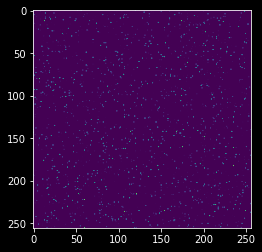

In [44]:
# o = torch.cat([torch.linspace(-1, 1, 128), torch.linspace(1, -1, 128)])
o = torch.ones(256, 256)
# print(o)
pattern = (o * 5).sigmoid()
# print(pattern)
pattern = norm_alpha(pattern, 0.825) - torch.rand(pattern.shape)
# pattern = pattern[:, None]
# print(pattern)
pattern = (pattern * 200).sigmoid()
# print(pattern)
plt.imshow(pattern.detach())
plt.show()

In [45]:
pattern.shape

torch.Size([256, 256])

In [12]:
data = next(iter(val_generator))

In [17]:
ks = Ft(data['img'] * data['std'] + data['mean'])
kdata = nufft_ob(IFt(ks).abs().cfloat().to(device), grid, smaps=smap.cfloat())
ks = kdata.reshape(ks.shape[0], 9, *ks.shape[-2:])
simg = IFt(ks * pattern.T[:, :, None].to(device)).abs().square().mean(1).sqrt()

In [23]:
pattern.T.shape

torch.Size([1, 256])

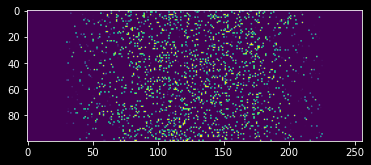

0.21919098671744852: 100%|██████████| 100/100 [24:03<00:00, 14.44s/it]


In [8]:
from collections import defaultdict

alpha = 1 / 16

bigo = torch.nn.Parameter(
    data=torch.cat([torch.linspace(-1, 1, 128), torch.linspace(1, -1, 128)]).to(device), 
    requires_grad=True)

pattern = (bigo.cpu().detach() * 5).sigmoid()
pattern = norm_alpha(pattern, alpha)[:, None] - torch.rand(pattern.shape[0], 100).to(pattern.device)
pattern = (pattern * 200).sigmoid()
plt.imshow(pattern.detach().T)
plt.show()

optimizer = torch.optim.Adam([bigo], lr=1e-2, weight_decay=0.)

history = defaultdict(list)

pbar = tqdm(range(100))
for epoch in pbar:
    for data in train_generator:
        # eval pattern
        pattern = (bigo * 5).sigmoid()
        pattern = norm_alpha(pattern, alpha)[:, None] - torch.rand(pattern.shape[0], 1).to(pattern.device)
        pattern = (pattern * 200).sigmoid()
        simg = IFt(Ft(data['img'] * data['std'] + data['mean']) * pattern.T[:, None]).abs()
        simg = (simg - data['mean']) / (data['std'] + 1e-11)
        simg = simg[:, :, None].view(-1, 1, simg.shape[-2], simg.shape[-1])
        # eval mask
        loss = dice_loss(data['mask'].long(), model(simg))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_([bigo], 1.0)
        optimizer.step()
    for data in val_generator:
        with torch.no_grad():
            # eval pattern
            pattern = (bigo * 5).sigmoid()
            pattern = norm_alpha(pattern, alpha)[:, None] - torch.rand(pattern.shape[0], 1).to(pattern.device)
            pattern = (pattern * 200).sigmoid()
            simg = IFt(Ft(data['img'] * data['std'] + data['mean']) * pattern.T[:, None]).abs()
            simg = (simg - data['mean']) / (data['std'] + 1e-11)
            simg = simg[:, :, None].view(-1, 1, simg.shape[-2], simg.shape[-1])
            # eval mask
            loss = dice_loss(data['mask'].long(), model(simg))
            history[epoch].append(loss.item())
    pbar.set_description(f'{np.mean(history[epoch])}')

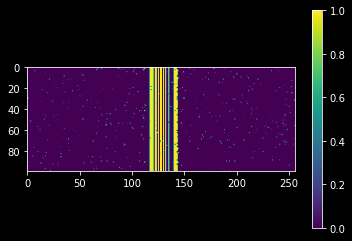

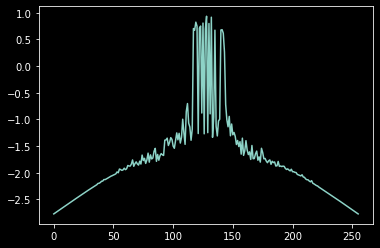

In [9]:
pattern = (bigo.cpu().detach() * 5).sigmoid()
pattern = norm_alpha(pattern, alpha)[:, None] - torch.rand(pattern.shape[0], 100).to(pattern.device)
pattern = (pattern * 200).sigmoid()
plt.imshow(pattern.detach().T)
plt.colorbar()
plt.show()

plt.plot(bigo.cpu().detach())
plt.show()

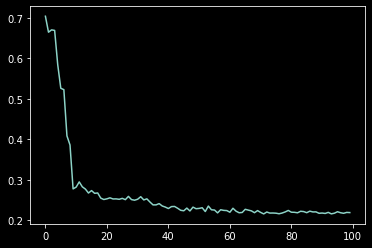

In [10]:
plt.plot([np.mean(history[i]) for i in range(len(history))])
plt.show()

tensor(16.)


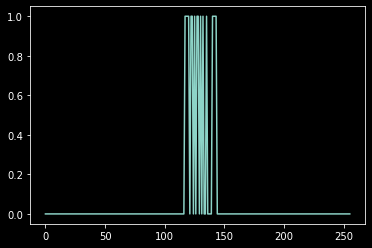

In [11]:
loupe_w = torch.zeros(256)
loupe_w[bigo.argsort()[-16:]] = 1
print(loupe_w.norm(p=1))
plt.plot(loupe_w)
plt.show()

In [12]:
!ls

acdc_igs_masks.pt  igs.pt	     multicoil_recon.ipynb  reparam_acdc.ipynb
igs2_acdc.ipynb    loupe_acdc.ipynb  nufft.ipynb	    reparam.pt
igs_acdc.ipynb	   loupe.pt	     pytorch_nufft	    toys.ipynb


In [13]:
torch.save(loupe_w, 'loupe.pt')
# our_w = torch.load('./igs.pt').to(device)
# loupe_w = torch.load('./loupe.pt').to(device)

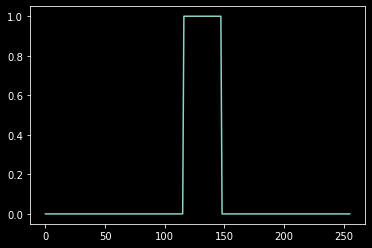

In [16]:
plt.plot(our_w.cpu())
# plt.plot(loupe_w.cpu())

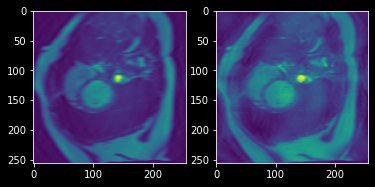

In [17]:
data = val_dataset[0]

plt.subplot(121)
simg = IFt(Ft(data['img'] * data['std'] + data['mean']) * our_w).abs()
plt.imshow(simg[0].cpu())

plt.subplot(122)
simg = IFt(Ft(data['img'] * data['std'] + data['mean']) * loupe_w).abs()
plt.imshow(simg[0].cpu())

plt.show()

In [12]:
dice_scores = dict(
    ours=test_sampling_pattern(our_w, model, train_generator),
    loupe=test_sampling_pattern(loupe_w, model, train_generator),
    fastmri=test_sampling_pattern(fastmri_mask_x16, model, train_generator), 
    center=test_sampling_pattern(zm, model, train_generator),
)

df_dice = pd.DataFrame.from_dict(dice_scores)
df_dice.describe()

,ours,loupe,fastmri,center
count,1188.000000,1188.000000,1188.000000,1188.000000
mean,0.758305,0.775712,0.543756,0.750143
std,0.199728,0.199158,0.217095,0.203426
min,0.245677,0.247115,0.240199,0.247175
25%,0.658155,0.677826,0.276659,0.649622
50%,0.857408,0.875303,0.579048,0.849317
75%,0.902092,0.912089,0.752053,0.897500
max,0.947442,0.951224,0.901179,0.944736


In [10]:
dice_class_scores = dict(
    fastmri=test_on_classes_sampling_pattern(fastmri_mask_x16, model, train_generator), 
    center=test_on_classes_sampling_pattern(zm, model, train_generator),
    ours=test_on_classes_sampling_pattern(our_w, model, train_generator),
    loupe=test_on_classes_sampling_pattern(loupe_w, model, train_generator),
    full=test_on_classes_sampling_pattern(fm, model, train_generator),
)

In [11]:
class_map = {0: 'RV cavity', 1: 'LV myo', 2: 'LV cavity'}
for name in dice_class_scores.keys():
    arr = np.array(dice_class_scores[name]).T
    print('##############', name, '##############')
    print(pd.DataFrame.from_dict({class_map[i]:arr[i] for i in range(arr.shape[0])}).describe())

############## fastmri ##############
         RV cavity       LV myo    LV cavity
count  1188.000000  1188.000000  1188.000000
mean      0.343976     0.328488     0.519749
std       0.359960     0.243407     0.379044
min       0.000000     0.000000     0.000000
25%       0.000000     0.005474     0.000000
50%       0.189320     0.389684     0.714790
75%       0.729195     0.536398     0.854421
max       0.936359     0.793284     0.960058
############## center ##############
         RV cavity       LV myo    LV cavity
count  1188.000000  1188.000000  1188.000000
mean      0.569106     0.663193     0.792257
std       0.389858     0.240588     0.302960
min       0.000000     0.000000     0.000000
25%       0.000000     0.641374     0.851632
50%       0.780408     0.750389     0.922185
75%       0.902080     0.809650     0.947078
max       0.975332     0.903067     0.980295
############## ours ##############
         RV cavity       LV myo    LV cavity
count  1188.000000  1188.000000  11